In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

In [2]:
from sklearn.datasets import load_boston
bostondata = load_boston()

The following commands will provide some basic information about the shape of the data:

In [188]:
print bostondata.keys()
print bostondata.feature_names
print bostondata.data.shape
print bostondata.target.shape
# uncomment the following if you want to see a lengthy description of the dataset
# print bostondata.DESCR

['data', 'feature_names', 'DESCR', 'target']
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)
(506,)


In [4]:
# Convert Boston data into a DataFrame
bdata = pd.DataFrame(bostondata.data)
bdata.columns = bostondata.feature_names
bdata["MEDV"] = bostondata.target
print bdata.head()


      CRIM  ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


---

##Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what we're dealing with.  

###: Histogram of housing prices



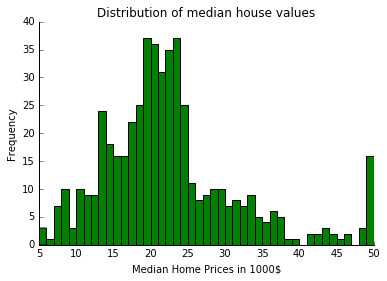

In [135]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

ax = plt.subplot(111)
ax.hist(bostondata.target,bins=45,color="g")
# Set the labels
ax.set_xlabel("Median Home Prices in 1000$")
ax.set_ylabel("Frequency")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top='off', right='off')
ax.set_title("Distribution of median house values")

###: Scatter plot of housing prices and crime


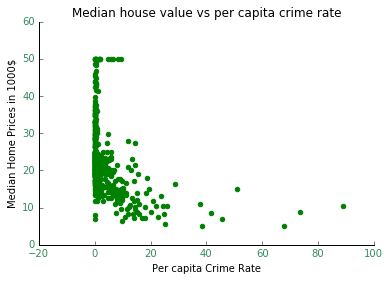

In [141]:
ax = plt.subplot(111)
ax.scatter(bdata.CRIM,bdata.MEDV,color="g")
# Set the labels
ax.set_ylabel("Median Home Prices in 1000$")
ax.set_xlabel("Per capita Crime Rate")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Median house value vs per capita crime rate")
ax.tick_params(labelcolor='seagreen', top='off', right='off')


###: Another visualization of the data

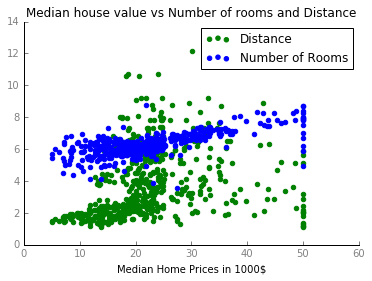

In [139]:
# enter your code here
ax = plt.subplot(111)
ax.scatter(bdata.MEDV,bdata.DIS,color="g")
ax.set_alpha(0.5)
ax.scatter(bdata.MEDV,bdata.RM,color="b")
ax.set_alpha(0.5)
ax.set_xlabel("Median Home Prices in 1000$")
plt.legend(('Distance','Number of Rooms'),)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Median house value vs Number of rooms and Distance")
ax.tick_params(labelcolor='grey', top='off', right='off')

A function to calculate Root Mean squared error of the data

In [8]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.16
"""
def compute_rmse(predictions, yvalues):
    # Ensure both the arrays have same size
    if len(predictions) == len(yvalues):
        # Cast the data into the np array format
        predictions = np.array(predictions)
        yvalues = np.array(yvalues)
        # Square the error and take mean and then sqrt
        rmse = np.sqrt(((predictions - yvalues) ** 2).mean())
        return rmse
    else:
        return "Array length should be same"

print compute_rmse((2,2,3),(0,2,6))
    

2.08166599947


###:Divide your data into training and testing datasets (66-34)


In [142]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)
from sklearn.cross_validation import train_test_split
# Split into train and test set
bdata_train,bdata_test = sklearn.cross_validation.train_test_split(bdata, test_size = 0.34) 
print len(bdata_test),len(bdata_train)

173 333


###: A very bad baseline to calculate the data. Assuming mean of the median values as the predicted value

In [144]:
# Predict median home value as the mean
medhomeval = np.mean(bdata_train["MEDV"])

# Compute RMSE for the predicted value for train data
predicted_train = [medhomeval for i in xrange(len(bdata_train))]
print compute_rmse(tuple(predicted_train),tuple(bdata_train["MEDV"]))

# Compute RMSE for the predicted value for train data
predicted_test = [medhomeval for i in xrange(len(bdata_test))]
print compute_rmse(tuple(predicted_test), tuple(bdata_test["MEDV"]))


9.43068967879
8.74957418914


The RMSE of the training set is 9.43 while the RMSE for the test set is 8.4795. The RMSE's are almost in the same range as is expected since the training and test set has been randomly assigned

---

##: Nearest Neighbors


Lets analyze the data using a Nearest Neighbor algorithm. To do this lets first make a distance function that calculates the L norm distance

In [23]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    #Check if length is equal
    if len(x1) == len(x2):
        #Calulate the L norm distance between the points
        dist = np.power(sum([np.power(x2[i]-x1[i],L) for i in range(len(x1))]),(1./L))
        return dist
    else:
        return "Length of the input arrays should be equal"
print distance((3,4),(6,8),2)

5.0


###: Basic Nearest Neighbor algorithm
The goal is to implement a basic nearest neighbor algorithm from scratch.  The simple model will use two input features (CRIM and RM) and a single output (MEDV).  We are modelling the relationship between median home value and crime rates and house size.

Use the training data (bdata_train) to "fit" the model, although, with Nearest Neighbors there is no real training, you just need to keep the training data in memory.  The function predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  The function takes L as an input, where L is passed to the distance function.

The function also computes the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  The time estimate of the total time taken by teh code to predict the nearest neighbors for all the values in the test data set is also calculated.

In [64]:
"""
Function
--------
nneighbor

Given features and a value for L, return the RMSE of the model

Parameters
----------
train_data : tuple
    DataFrame of features to be considered for the model as a tuple and the output 
    
test_data : tuple
    DataFrame of features to be considered for the model and the actual output

L: int
    Value of L to use in computing distances

Returns
-------
rmse : int
    The RMSE of the model

Example
-------
>>> print nneighbor(['CRIM','RM'],2)
6.68101
"""

import time
def nneighbor(train_data,test_data, L,verbose=False):
    start_time = time.time()
    # Predict the nearest neighbor
    predicted_op=[]
    for row in test_data:
        dist = [(distance(tr[0],row[0],L),tr[1]) for tr in train_data]
        predicted_op.append(min(dist,key=lambda t: t[0])[1])
    rmse = compute_rmse(predicted_op,[t[1] for t in test_data])
    if verbose:
        print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return rmse

#your additional code here
tr_data = [((tr["CRIM"],tr["RM"]),tr["MEDV"]) for ind,tr in bdata_train.iterrows()]
tt_data = [((tt["CRIM"],tt["RM"]),tt["MEDV"]) for ind,tt in bdata_test.iterrows()]
# print tr_data
nneighbor(tr_data,tt_data,2,True)

Time taken: 0.51 seconds


6.6810100998095514

The code takes ~0.51sec to run. For the test set the RMSE is 6.681

###:Normalization

The data is not normalized which is a big no-no in terms of Nerarest Neighbors algorithm.  The normalize function is a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

I also re run the nneighbor on the normalized data

In [173]:
"""
Function
--------
normalize

Given a raw_data, normalize and return the normalized data

Parameters
----------
raw_data : array
    The list of data to be normalized 

Returns
-------
normalized_data : array
    The normalized array for the raw_data

Example
-------
>>> print normalize(bdata_test["RM"])
"""
def normalize(raw_data):
    #your code here
    m = np.mean(raw_data)
    stdv = np.std(raw_data)
    normalized_data = [(x-m)/stdv for x in raw_data]
    return normalized_data

#Create the dataframe to hold the normalized data
bdata_test_normalized = pd.DataFrame()
bdata_train_normalized = pd.DataFrame()
# For every column normalize the data except for the median value
for col in bdata_train:
    if col != "MEDV":
        bdata_test_normalized[col] = normalize(bdata_test[col])
        bdata_train_normalized[col] = normalize(bdata_train[col])
    else:
        bdata_test_normalized[col] = bdata_test[col].values.tolist()
        bdata_train_normalized[col] = bdata_train[col].values.tolist()
tr_data = [((tr["CRIM"],tr["RM"]),tr["MEDV"]) for ind,tr in bdata_train_normalized.iterrows()]
tt_data = [((tt["CRIM"],tt["RM"]),tt["MEDV"]) for ind,tt in bdata_test_normalized.iterrows()]
# print tr_data
nneighbor(tr_data,tt_data,2)

6.8009732387519106

The RMSE in before normalization was 6.68 and after normalization has been 6.800. I have normalized all the features in the dataset but not the output variables.

###Adding more features
 We have used the same set of features until not. Let's explore what happens as we add more features

In [175]:
# Try adding DIS as a feature
tr_data = [((tr["CRIM"],tr["RM"],tr["DIS"]),tr["MEDV"]) for ind,tr in bdata_train_normalized.iterrows()]
tt_data = [((tt["CRIM"],tt["RM"],tt["DIS"]),tt["MEDV"]) for ind,tt in bdata_test_normalized.iterrows()]
# print tr_data
print "Adding DIS into the equation"
print nneighbor(tr_data,tt_data,2,True)


tr_data = [((tr["CRIM"],tr["RM"],tr["DIS"],tr["NOX"]),tr["MEDV"]) for ind,tr in bdata_train_normalized.iterrows()]
tt_data = [((tt["CRIM"],tt["RM"],tt["DIS"],tt["NOX"]),tt["MEDV"]) for ind,tt in bdata_test_normalized.iterrows()]
# print tr_data
print "Adding NOX into the equation"
print nneighbor(tr_data,tt_data,2,True)

Adding DIS into the equation
Time taken: 0.65 seconds
6.36819681196
Adding NOX into the equation
Time taken: 0.81 seconds
5.86041881358


Adding DIS to the equation reduced the RMSE to 6.36. Further the RMSE reduced to 5.86 as I added NOX as a feature. The running time of the algorithm also increases as new features are added. It went from 0.65sec to 0.81 sec as I added DIS and then NOX respectively.

###: Cross-Validation

Over fitting is one of the biggest issues we can face in creating a good model. Below I have created a k fold cross validation function that validates the data. 

In [182]:
"""
Function
--------
k_fold_cross_validation

Perform a k fold cross validation

Parameters
----------
K : int
    The number of folds required

data : array
    The list of data to be used for k fold validation
    
method: string
    The type of method i.e nneighbors or knn
    
knn: int
    The number of neighbors to be considered for knn

Returns
-------
mean_rmse : number
    The mean RMSE of the k fold validation 

Example
-------
>>> print k_fold_cross_validation(10,kdata,"nneighbor")
7.59766
"""
def k_fold_cross_validation(K,data,method,kn=1,verbose=False):
    start_time = time.time()
    output_rmse = []
    n = len(data)
    for fold in xrange(K):
        tr_data=[]
        tt_data=[]
        for i in xrange(n):
            if i % K != fold:
                tr_data.append(data[i])
            else:
                tt_data.append(data[i])
        if method == "nneighbor":
            output_rmse.append(nneighbor(tr_data,tt_data,2))
        else:
            output_rmse.append(knn(tr_data,tt_data,2,kn))
        if verbose:
            print "K:",fold+1,"RMSE: ",output_rmse[-1]
    if verbose:
        print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return np.mean(output_rmse)        
    
kdata = [((tr["CRIM"],tr["RM"]),tr["MEDV"]) for ind,tr in bdata_train.iterrows()]     
k_fold_cross_validation(10,kdata,"nneighbor",1,True)
    

K: 1 RMSE:  9.74210087259
K: 2 RMSE:  9.05994740927
K: 3 RMSE:  4.59382577969
K: 4 RMSE:  6.75528973427
K: 5 RMSE:  7.74565371774
K: 6 RMSE:  10.0253466652
K: 7 RMSE:  7.42530480958
K: 8 RMSE:  8.6385675019
K: 9 RMSE:  7.53271652074
K: 10 RMSE:  4.45791770932
Time taken: 0.98 seconds


7.5976670720303856

The average RMSE for the data set is 7.59. This is only for the training data set. The total time taken for the 10 fold cross validation is 0.98 sec

###: K-Nearest Neighbors Algorithm

In [183]:
"""
Function
--------
knn

Given a training_data and test data find the k nearest neighbor and calculate RMSE 

Parameters
----------
train_data : array
    A list of tuples of features and an output for training 
    
L : int
    A number for calculating L norm 
    
K : int
    Number of neighbors to be considered  

Returns
-------
rmse : int
    The rmse of the test set

Example
-------
>>> print knn(train,test,2,5)
6.36
"""
def knn(train_data,test_data, L, K,verbose=False):
    # Capture start time
    start_time = time.time()
    # Predict the K nearest neighbors
    predicted_op=[]
    # For each record in test data find K least distance y's
    for row in test_data:
        dist = [(distance(tr[0],row[0],L),tr[1]) for tr in train_data]
#         dist = np.mean(sorted(dist,key=lambda t:t[0])[:K])
        dist= [x[1] for x in (sorted(dist,key=lambda t:t[0])[:K])] 
#         print np.mean(dist)
        predicted_op.append(np.mean(dist)) # Take mean of the nearest K values
#     print predicted_op
    rmse = compute_rmse(predicted_op,[t[1] for t in test_data])
    if verbose:
        print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return rmse

# Test the function using 10 fold cross validation
tr_data = [((tr["CRIM"],tr["RM"]),tr["MEDV"]) for ind,tr in bdata_train.iterrows()]
tt_data = [((tt["CRIM"],tt["RM"]),tt["MEDV"]) for ind,tt in bdata_test.iterrows()]
k_fold_cross_validation(10,tr_data,"knn",3)

6.3683098412622767

The RMSE for for KNN with k=3 using the 10 fold cross validation is 6.36

###: Checking for the effect of varying K on the RMSE of the model.

In [201]:
# Calculate RMSE for K 1-25
tr_data = [((tr["CRIM"],tr["RM"],tr["ZN"],tr["DIS"],tr["TAX"],tr["AGE"]),tr["MEDV"]) for ind,tr in bdata_train_normalized.iterrows()]
krmse=[]
for i in xrange(1,26):
    krmse.append(k_fold_cross_validation(10,tr_data,"knn",i))
    print "K: ",i,"RMSE: ",krmse[-1]

K:  1 RMSE:  6.27021844927
K:  2 RMSE:  5.7529522649
K:  3 RMSE:  5.85172539052
K:  4 RMSE:  5.69614088204
K:  5 RMSE:  5.70485023736
K:  6 RMSE:  5.7416218371
K:  7 RMSE:  5.79247809632
K:  8 RMSE:  5.78187155311
K:  9 RMSE:  5.83513618505
K:  10 RMSE:  5.78962677309
K:  11 RMSE:  5.79436340383
K:  12 RMSE:  5.8743862947
K:  13 RMSE:  5.89934062738
K:  14 RMSE:  5.88353122877
K:  15 RMSE:  5.93910304189
K:  16 RMSE:  6.02069038835
K:  17 RMSE:  5.97558690211
K:  18 RMSE:  5.99859328819
K:  19 RMSE:  6.03454028647
K:  20 RMSE:  6.06738736188
K:  21 RMSE:  6.0916149615
K:  22 RMSE:  6.08124481703
K:  23 RMSE:  6.09916289201
K:  24 RMSE:  6.12261993531
K:  25 RMSE:  6.16320278768


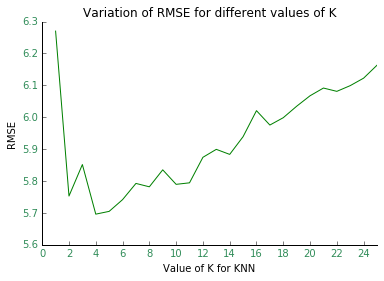

In [206]:
# plt.plot(krmse)
dim = np.arange(1,25,1)
ax = plt.subplot(111)
d = [ i for i in xrange(1,26)]
ax.plot(d,krmse,color="g")
# Set the labels
ax.set_ylabel("RMSE")
ax.set_xlabel("Value of K for KNN")
# Hide the right and top spines
ax.xaxis.set_ticks(xrange(0,25,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Variation of RMSE for different values of K")
ax.tick_params(labelcolor='seagreen', top='off', right='off')


From the graph above we can see that as the value of K increases, the value of RMSE first decreases, hits a low at k=4 and then increases again. Thus the best value of K for this model is 4.